**Импорт библиотек**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
plt.style.use('ggplot')
import plotly.express as px
#pd.options.plotting.backend = "plotly"

In [8]:
!pip install catboost xgboost lightgbm scikit-learn pandas numpy matplotlib seaborn scipy -q

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [10]:
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

# Импорт файла. Первичный анализ

In [11]:
import pandas as pd
from google.colab import files
import io

# 1. Загружаем Excel файл с компьютера
uploaded = files.upload()

# 2. Получаем имя файла
filename = next(iter(uploaded.keys()))
print(f"Загружен файл: {filename}")

# 3. Читаем Excel в датафрейм
df = pd.read_excel(io.BytesIO(uploaded[filename]))

Saving fake_social_media_global_2.0_with_missing.xlsx to fake_social_media_global_2.0_with_missing (1).xlsx
Загружен файл: fake_social_media_global_2.0_with_missing (1).xlsx


In [12]:
df.head()

,platform,has_profile_pic,bio_length,username_randomness,followers,following,follower_following_ratio,account_age_days,posts,posts_per_day,...,generic_comment_rate,suspicious_links_in_bio,verified,is_fake,username,username_length,digits_count,digit_ratio,special_char_count,repeat_char_count
0,X,1.0,180.0,1.0,431.0,679.0,0.633824,NaN,NaN,0.205945,...,5.0,1.0,0.0,0,dmitri,6,0,0.000000,0,0
1,NaN,1.0,214.0,NaN,426.0,729.0,0.583562,3164.0,202.0,0.063823,...,141.0,NaN,1.0,1,smpni6240,9,4,0.444444,0,0
2,X,1.0,87.0,NaN,426.0,721.0,0.590028,903.0,225.0,0.248894,...,62.0,1.0,0.0,1,qgph5q343j,10,4,0.400000,0,0
3,X,0.0,72.0,0.0,385.0,NaN,0.566176,3433.0,175.0,0.050961,...,117.0,1.0,1.0,0,mia,3,0,0.000000,0,0
4,Instagram,0.0,162.0,NaN,392.0,709.0,0.552113,NaN,207.0,0.162992,...,64.0,NaN,1.0,0,martin,6,0,0.000000,0,0


Датасет содержит данные о пользователях соц. сетей, описание характиристик аккаунтов, а также сведения о том, фейковый ли аккаунт. **Целевая переменная: is_fake - прямо указывает, является ли аккаунт фейковым (1) или нет (0)**

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   platform                  2667 non-null   object 
 1   has_profile_pic           2655 non-null   float64
 2   bio_length                2671 non-null   float64
 3   username_randomness       2663 non-null   float64
 4   followers                 2662 non-null   float64
 5   following                 2667 non-null   float64
 6   follower_following_ratio  2644 non-null   float64
 7   account_age_days          2657 non-null   float64
 8   posts                     2683 non-null   float64
 9   posts_per_day             2689 non-null   float64
 10  caption_similarity_score  2670 non-null   float64
 11  content_similarity_score  2672 non-null   float64
 12  follow_unfollow_rate      2692 non-null   float64
 13  spam_comments_rate        2662 non-null   float64
 14  generic_

In [14]:
df.describe()

,has_profile_pic,bio_length,username_randomness,followers,following,follower_following_ratio,account_age_days,posts,posts_per_day,caption_similarity_score,...,spam_comments_rate,generic_comment_rate,suspicious_links_in_bio,verified,is_fake,username_length,digits_count,digit_ratio,special_char_count,repeat_char_count
count,2655.000000,2671.000000,2663.000000,2662.000000,2667.000000,2644.000000,2657.000000,2683.000000,2689.000000,2670.000000,...,2662.000000,2633.000000,2640.000000,2663.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.492655,124.181206,0.503192,399.984222,700.841395,0.570651,2490.854347,200.295937,0.273948,0.503490,...,99.440270,74.568173,0.503409,0.494931,0.353000,9.057333,3.051333,0.314868,0.540000,0.335000
std,0.500040,71.199830,0.500084,20.082031,25.841196,0.035102,1436.750871,14.233918,1.693301,0.286027,...,57.970155,43.672848,0.500083,0.500068,0.477982,2.215479,1.777381,0.183668,0.498481,0.544861
min,0.000000,0.000000,0.000000,334.000000,616.000000,0.467377,2.000000,151.000000,0.034999,0.000146,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,65.000000,0.000000,387.000000,684.000000,0.545967,1247.000000,190.000000,0.053500,0.259749,...,49.000000,36.000000,0.000000,0.000000,0.000000,8.000000,2.000000,0.166667,0.000000,0.000000
50%,0.000000,124.000000,1.000000,400.000000,701.000000,0.570800,2455.000000,200.000000,0.080808,0.510672,...,100.000000,76.000000,1.000000,0.000000,0.000000,9.000000,4.000000,0.400000,1.000000,0.000000
75%,1.000000,184.500000,1.000000,413.000000,718.000000,0.593853,3746.000000,209.000000,0.160743,0.748773,...,149.000000,111.000000,1.000000,1.000000,1.000000,10.000000,4.000000,0.444444,1.000000,1.000000
max,1.000000,249.000000,1.000000,472.000000,789.000000,0.693679,4997.000000,254.000000,73.333333,0.999496,...,199.000000,149.000000,1.000000,1.000000,1.000000,14.000000,8.000000,0.800000,1.000000,3.000000


In [15]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nЧисловые колонки ({len(numeric_cols)}): {numeric_cols}")
print(f"Категориальные колонки ({len(categorical_cols)}): {categorical_cols}")


Числовые колонки (22): ['has_profile_pic', 'bio_length', 'username_randomness', 'followers', 'following', 'follower_following_ratio', 'account_age_days', 'posts', 'posts_per_day', 'caption_similarity_score', 'content_similarity_score', 'follow_unfollow_rate', 'spam_comments_rate', 'generic_comment_rate', 'suspicious_links_in_bio', 'verified', 'is_fake', 'username_length', 'digits_count', 'digit_ratio', 'special_char_count', 'repeat_char_count']
Категориальные колонки (2): ['platform', 'username']


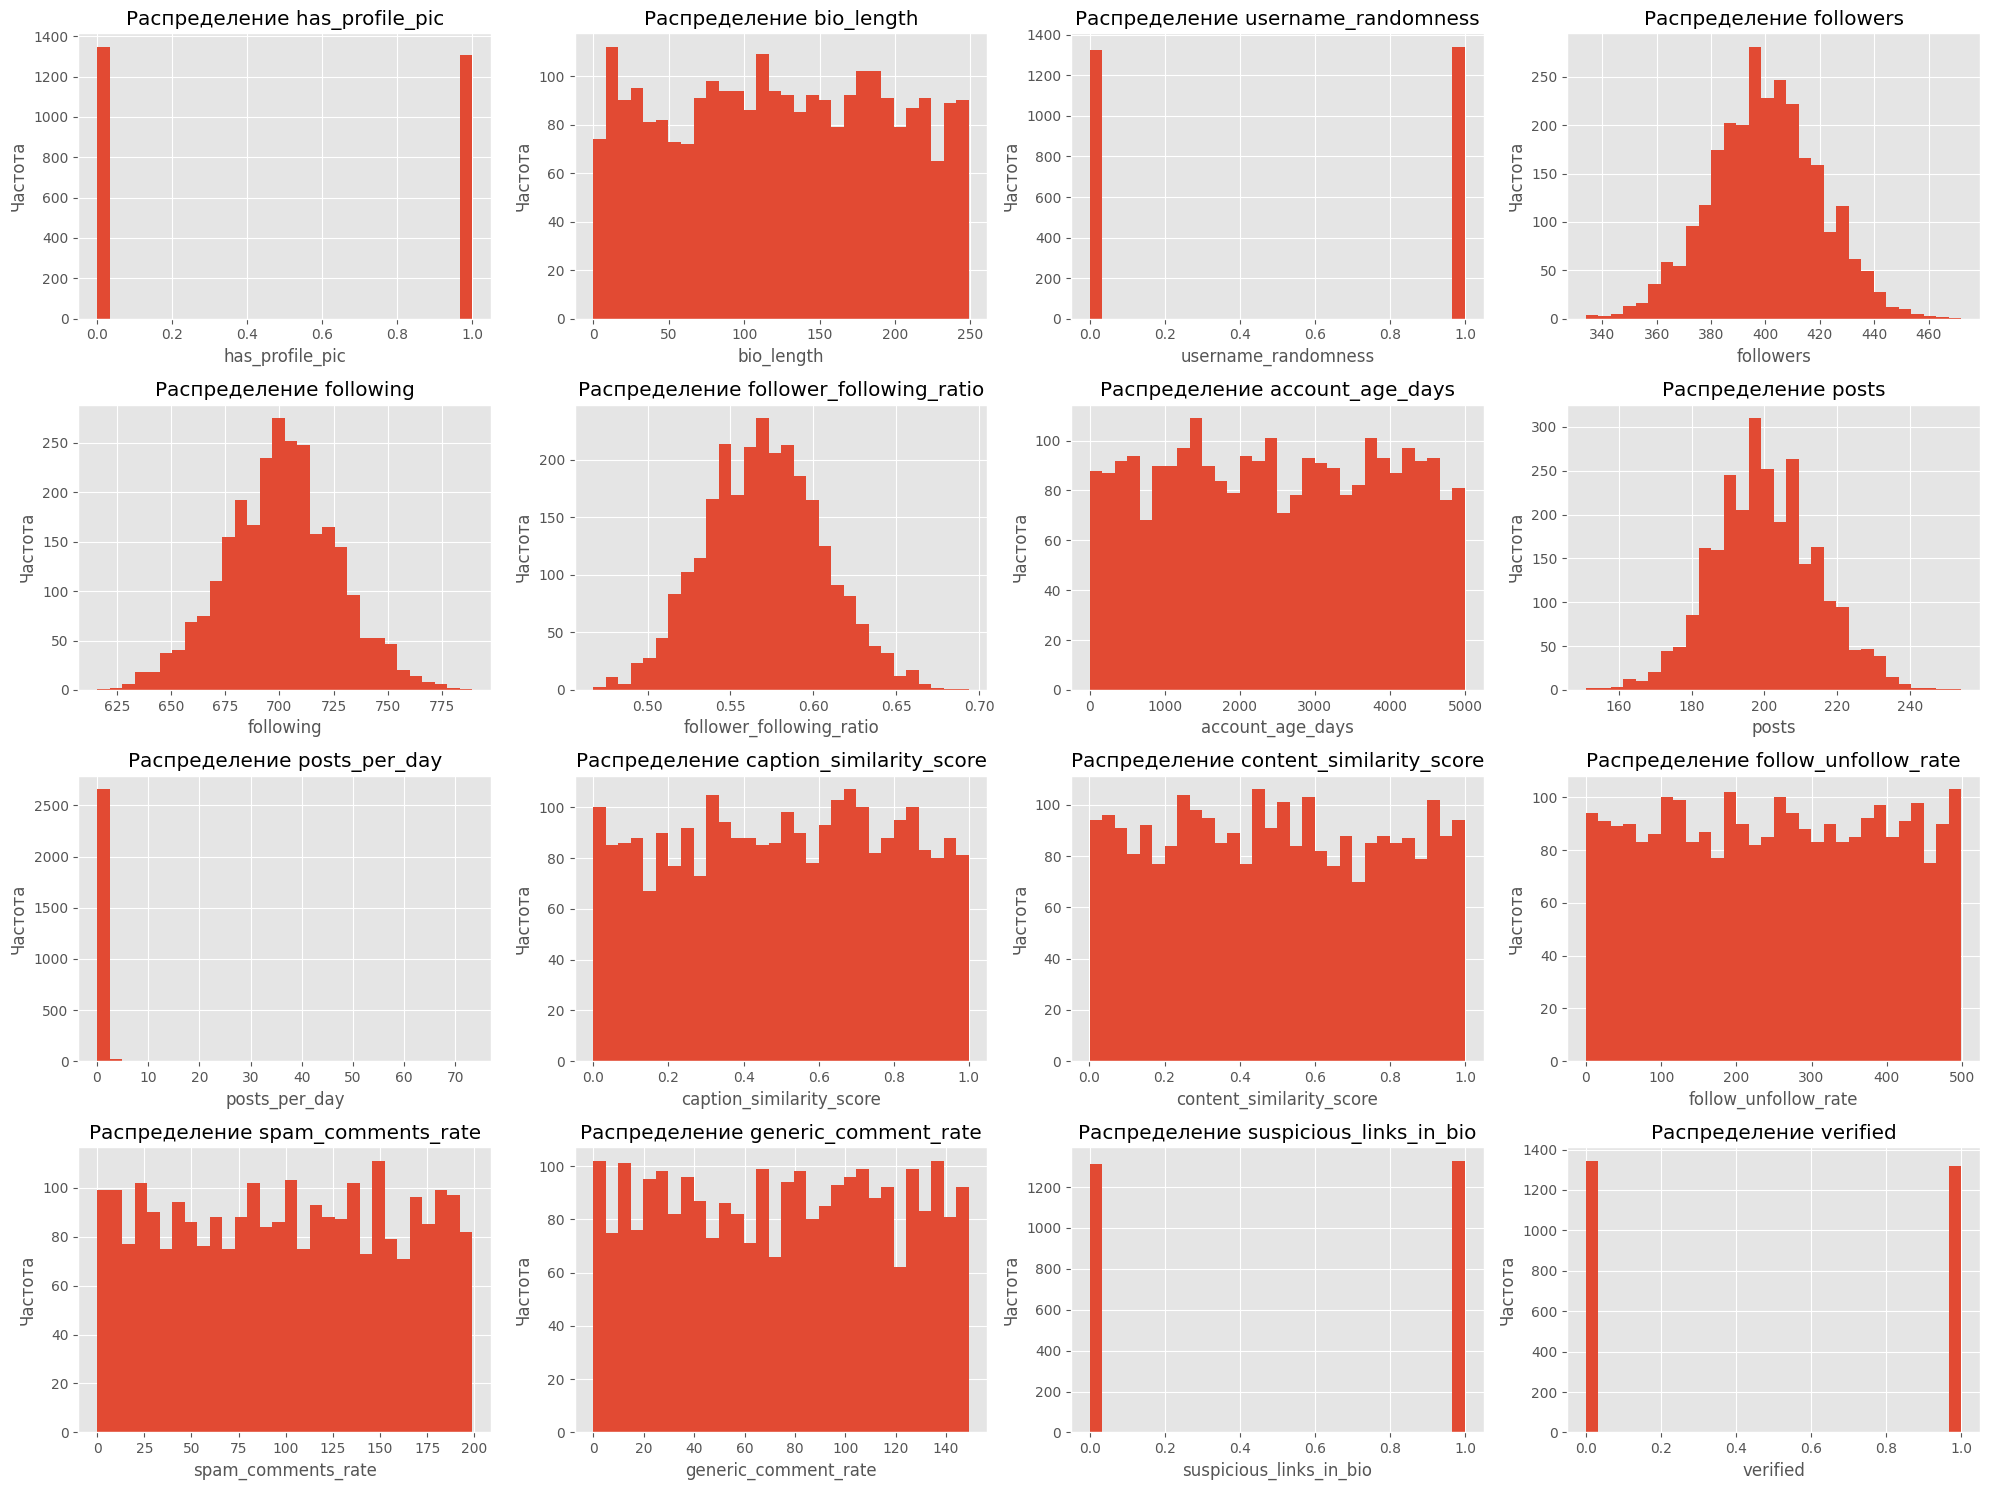

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:16]):
    if col in df.columns:
        df[col].hist(ax=axes[i], bins=30)
        axes[i].set_title(f'Распределение {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

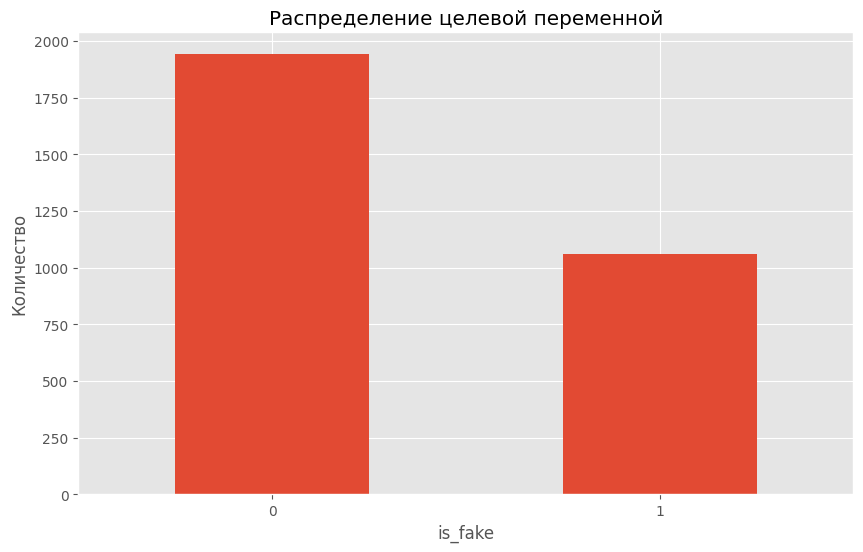

In [17]:
if 'is_fake' in df.columns:
    plt.figure(figsize=(10, 6))
    df['is_fake'].value_counts().plot(kind='bar')
    plt.title('Распределение целевой переменной')
    plt.xlabel('is_fake')
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.show()


#Обработка пропусков

In [18]:
df.duplicated().sum()

np.int64(0)

In [19]:
df.isnull().sum()

,0
platform,333
has_profile_pic,345
bio_length,329
username_randomness,337
followers,338
following,333
follower_following_ratio,356
account_age_days,343
posts,317
posts_per_day,311


In [20]:
df_null=df.copy()

Для бинарных признаков - заполнение модой

In [21]:
binary_cols = ['has_profile_pic', 'suspicious_links_in_bio', 'verified', 'is_fake', 'username_randomness']
for col in binary_cols:
    if col in df_null.columns:
        mode_val = df_null[col].mode()[0] if not df_null[col].mode().empty else 0
        df_null[col] = df_null[col].fillna(mode_val)


Для категориальных признаков - специальные значения

In [22]:
categorical_cols = ['platform']
for col in categorical_cols:
    if col in df_null.columns:
        if df_null[col].isnull().any():
            df_null[col] = df_null[col].fillna('Unknown')

Для числовых признаков - медиана

In [23]:
numeric_cols = ['bio_length', 'username_randomness', 'followers', 'following', 'account_age_days',
                'posts', 'posts_per_day', 'caption_similarity_score',
                'content_similarity_score', 'follow_unfollow_rate',
                'spam_comments_rate', 'generic_comment_rate']

for col in numeric_cols:
    if col in df_null.columns and df_null[col].isnull().any():
        # Используем медиану для заполнения
        median_val = df_null[col].median()
        df_null[col] = df_null[col].fillna(median_val)

follower_following_ratio -- для пустых значений вычисляем заново: подписчики/подписки

In [24]:
if 'follower_following_ratio' in df_null.columns:
    mask = df_null['follower_following_ratio'].isnull()
    df_null.loc[mask, 'follower_following_ratio'] = df_null.loc[mask, 'followers'] / df_null.loc[mask, 'following']
    # Заполняем оставшиеся пропуски медианой
    df_null['follower_following_ratio'] = df_null['follower_following_ratio'].fillna(
        df_null['follower_following_ratio'].median()
    )

In [25]:
df_null.isnull().sum()

,0
platform,0
has_profile_pic,0
bio_length,0
username_randomness,0
followers,0
following,0
follower_following_ratio,0
account_age_days,0
posts,0
posts_per_day,0


In [26]:
df_null.head()

,platform,has_profile_pic,bio_length,username_randomness,followers,following,follower_following_ratio,account_age_days,posts,posts_per_day,...,generic_comment_rate,suspicious_links_in_bio,verified,is_fake,username,username_length,digits_count,digit_ratio,special_char_count,repeat_char_count
0,X,1.0,180.0,1.0,431.0,679.0,0.633824,2455.0,200.0,0.205945,...,5.0,1.0,0.0,0,dmitri,6,0,0.000000,0,0
1,Unknown,1.0,214.0,1.0,426.0,729.0,0.583562,3164.0,202.0,0.063823,...,141.0,1.0,1.0,1,smpni6240,9,4,0.444444,0,0
2,X,1.0,87.0,1.0,426.0,721.0,0.590028,903.0,225.0,0.248894,...,62.0,1.0,0.0,1,qgph5q343j,10,4,0.400000,0,0
3,X,0.0,72.0,0.0,385.0,701.0,0.566176,3433.0,175.0,0.050961,...,117.0,1.0,1.0,0,mia,3,0,0.000000,0,0
4,Instagram,0.0,162.0,1.0,392.0,709.0,0.552113,2455.0,207.0,0.162992,...,64.0,1.0,1.0,0,martin,6,0,0.000000,0,0


#Определение и обработка выбросов

In [27]:
import plotly.express as px
import numpy as np

# Выбираем ключевые числовые признаки для анализа
key_features = ['followers', 'following', 'account_age_days', 'posts_per_day',
                'follower_following_ratio', 'bio_length', 'follow_unfollow_rate',
                'spam_comments_rate']

# Создаем графики для каждого признака
for feature in key_features:
    if feature in df_null.columns:
        # Рассчитываем статистику
        Q1 = df_null[feature].quantile(0.25)
        Q3 = df_null[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df_null[(df_null[feature] < lower_bound) | (df_null[feature] > upper_bound)]
        outlier_count = len(outliers)

        # Создаем график
        fig = px.box(
            df_null,
            y=feature,
            title=f'<b>{feature}</b><br>Выбросов: {outlier_count}',
            labels={feature: 'Значение'}
        )

        # Настраиваем внешний вид
        fig.update_traces(
            boxpoints='outliers',
            marker=dict(
                color='lightblue',
                size=6,
                opacity=0.6
            ),
            line=dict(
                color='darkblue'
            ),
            fillcolor='lightblue'
        )

        fig.update_layout(
            height=400,
            width=600,
            title_font=dict(size=14),
            showlegend=False,
            yaxis_title='Значение',
            paper_bgcolor='white',
            plot_bgcolor='white'
        )

        fig.show()

In [28]:
# Обработка выбросов - обрезка по 5-95 перцентилям
df_no_outliers = df_null.copy()

key_numeric = ['followers', 'following', 'account_age_days', 'posts_per_day',
               'follower_following_ratio', 'bio_length', 'follow_unfollow_rate',
               'spam_comments_rate', 'generic_comment_rate']

for col in key_numeric:
    if col in df_no_outliers.columns:
        Q1 = df_no_outliers[col].quantile(0.05)
        Q3 = df_no_outliers[col].quantile(0.95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_no_outliers[col] = df_no_outliers[col].clip(lower_bound, upper_bound)

In [29]:
for i, col in enumerate(key_numeric):
    # Рассчитываем статистику
    Q1 = df_no_outliers[col].quantile(0.05)
    Q3 = df_no_outliers[col].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_no_outliers[(df_no_outliers[col] < lower_bound) | (df_no_outliers[col] > upper_bound)]
    outlier_count = len(outliers)

    fig = px.box(
        df_no_outliers,
        y=col,
        title=f'<b>{col}</b><br>Выбросов после обработки: {outlier_count}',
        labels={col: 'Значение'},
        points='outliers'
    )

    # Настраиваем оформление
    fig.update_traces(
        marker=dict(color='lightgreen', size=8, opacity=0.6),
        line=dict(color='darkgreen', width=2),
        fillcolor='lightgreen'
    )

    fig.update_layout(
        height=500,
        width=600,
        title_font=dict(size=14),
        showlegend=False,
        yaxis_title='Значение',
        paper_bgcolor='white',
        plot_bgcolor='white',
        xaxis=dict(showticklabels=False)
    )

    # Добавляем аннотации
    fig.add_annotation(
        x=0.5, y=0.95,
        xref="paper", yref="paper",
        text=f"Q1: {Q1:.1f} | Q3: {Q3:.1f} | IQR: {IQR:.1f}",
        showarrow=False,
        font=dict(size=10),
        bgcolor='lightyellow',
        bordercolor='gold',
        borderwidth=1
    )

    fig.show()

#Матрица корреляции

In [30]:
correlation_matrix = df_no_outliers.select_dtypes(include=[np.number]).corr()


fig = px.imshow(
    correlation_matrix,
    text_auto='.2f',
    aspect='auto',
    color_continuous_scale='RdBu_r',
    color_continuous_midpoint=0,
    title='<b>Матрица корреляций всех признаков</b>',
    labels=dict(color="Корреляция")
)

# Настраиваем отображение
fig.update_layout(
    width=1200,
    height=1000,
    title_x=0.5,
    title_font=dict(size=16),
    xaxis_title="Признаки",
    yaxis_title="Признаки"
)

fig.update_xaxes(tickangle=50)
fig.show()

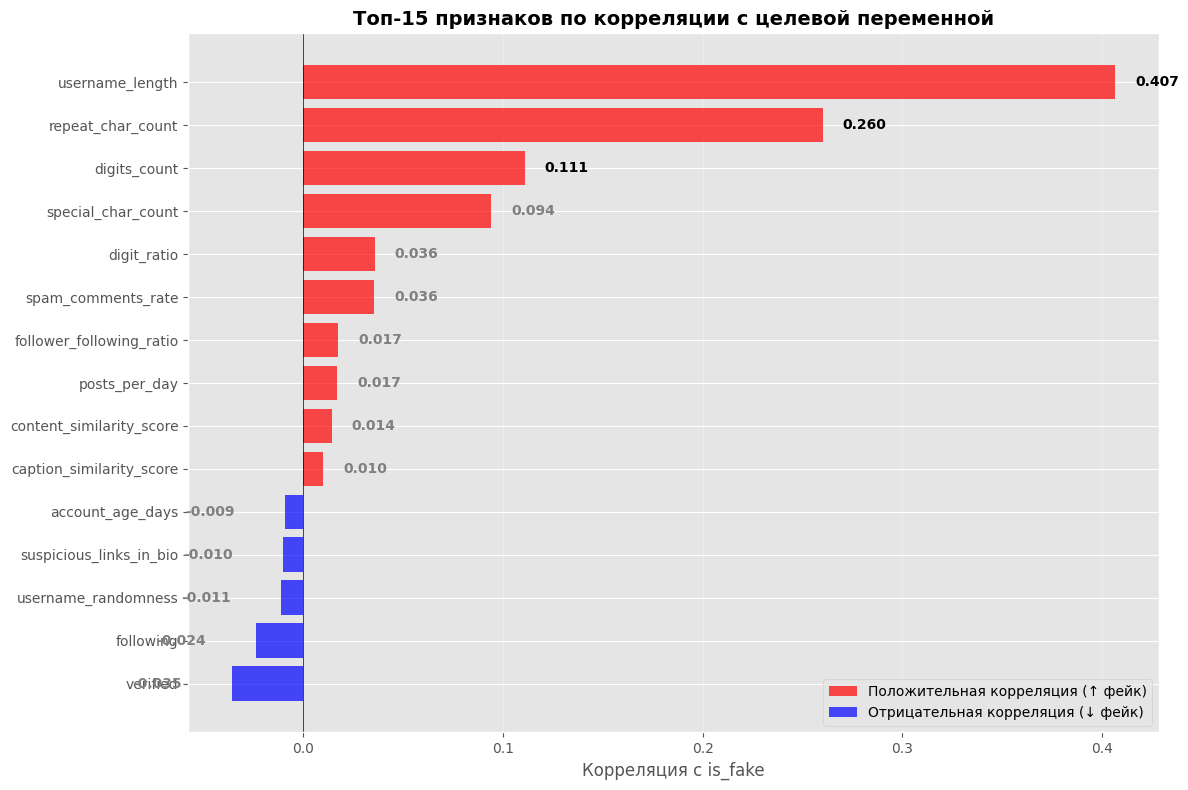


Топ-15 признаков по корреляции с is_fake:
----------------------------------------------------------------------
                 Признак  Корреляция  Абс.корреляция Направление
         username_length    0.406598        0.406598      ↑ фейк
       repeat_char_count    0.260210        0.260210      ↑ фейк
            digits_count    0.110933        0.110933      ↑ фейк
      special_char_count    0.093960        0.093960      ↑ фейк
             digit_ratio    0.035808        0.035808      ↑ фейк
      spam_comments_rate    0.035579        0.035579      ↑ фейк
follower_following_ratio    0.017336        0.017336      ↑ фейк
           posts_per_day    0.016840        0.016840      ↑ фейк
content_similarity_score    0.014268        0.014268      ↑ фейк
caption_similarity_score    0.010089        0.010089      ↑ фейк
        account_age_days   -0.008962        0.008962      ↓ фейк
 suspicious_links_in_bio   -0.010148        0.010148      ↓ фейк
     username_randomness   -0.011212     

In [31]:
# 2. ГРАФИК ТОП ПРИЗНАКОВ КОРРЕЛИРУЮЩИХ С is_fake

if 'is_fake' in df_no_outliers.columns:
    # Получаем корреляции с целевым признаком
    target_correlations = correlation_matrix['is_fake'].drop('is_fake')

    # Сортируем по абсолютному значению
    target_correlations_sorted = target_correlations.abs().sort_values(ascending=False)

    # Берем топ-15 признаков
    top_n = 15
    top_features = target_correlations_sorted.head(top_n).index
    top_correlations = target_correlations[top_features]

    # Создаем график
    plt.figure(figsize=(12, 8))

    # Сортируем по значению корреляции
    top_correlations_sorted = top_correlations.sort_values()

    # Создаем bar chart
    colors = ['red' if val > 0 else 'blue' for val in top_correlations_sorted.values]
    bars = plt.barh(range(len(top_correlations_sorted)), top_correlations_sorted.values, color=colors, alpha=0.7)

    # Настройки графика
    plt.yticks(range(len(top_correlations_sorted)), top_correlations_sorted.index)
    plt.xlabel('Корреляция с is_fake', fontsize=12)
    plt.title(f'Топ-{top_n} признаков по корреляции с целевой переменной', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

    # Добавляем значения
    for i, (feature, corr) in enumerate(top_correlations_sorted.items()):
        plt.text(corr + (0.01 if corr >= 0 else -0.05), i, f'{corr:.3f}',
                va='center', fontsize=10, fontweight='bold',
                color='black' if abs(corr) > 0.1 else 'gray')

    # Добавляем легенду
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.7, label='Положительная корреляция (↑ фейк)'),
                      Patch(facecolor='blue', alpha=0.7, label='Отрицательная корреляция (↓ фейк)')]
    plt.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.show()

    # Выводим таблицу с топ признаками
    print("\nТоп-15 признаков по корреляции с is_fake:")
    print("-" * 70)

    top_table = pd.DataFrame({
        'Признак': top_correlations_sorted.index[::-1],  # Разворачиваем для удобства чтения
        'Корреляция': top_correlations_sorted.values[::-1],
        'Абс.корреляция': top_correlations_sorted.abs().values[::-1],
        'Направление': ['↑ фейк' if x > 0 else '↓ фейк' for x in top_correlations_sorted.values[::-1]]
    })

    print(top_table.to_string(index=False))

else:
    print("Целевой признак 'is_fake' не найден!")

Выявалена как положительное так и отрицательное значение корреляции. Фейковые аккаунты чаще всего отличаются от настоящих структурой названия ника: они имеют более длинные имена с повторяющимися символами и цифрами. Остальные признаки (активность, метрики профиля, схожесть контента) имеют очень слабое линейное влияние на целевую переменную.

#Гипотизы. Визуализация данных

In [32]:
df_no_outliers.head()

,platform,has_profile_pic,bio_length,username_randomness,followers,following,follower_following_ratio,account_age_days,posts,posts_per_day,...,generic_comment_rate,suspicious_links_in_bio,verified,is_fake,username,username_length,digits_count,digit_ratio,special_char_count,repeat_char_count
0,X,1.0,180.0,1.0,431.0,679.0,0.633824,2455.0,200.0,0.205945,...,5.0,1.0,0.0,0,dmitri,6,0,0.000000,0,0
1,Unknown,1.0,214.0,1.0,426.0,729.0,0.583562,3164.0,202.0,0.063823,...,141.0,1.0,1.0,1,smpni6240,9,4,0.444444,0,0
2,X,1.0,87.0,1.0,426.0,721.0,0.590028,903.0,225.0,0.248894,...,62.0,1.0,0.0,1,qgph5q343j,10,4,0.400000,0,0
3,X,0.0,72.0,0.0,385.0,701.0,0.566176,3433.0,175.0,0.050961,...,117.0,1.0,1.0,0,mia,3,0,0.000000,0,0
4,Instagram,0.0,162.0,1.0,392.0,709.0,0.552113,2455.0,207.0,0.162992,...,64.0,1.0,1.0,0,martin,6,0,0.000000,0,0


### Гипотеза 1: Фейковые аккаунты имеют бо́льшую длину имени пользователя

In [33]:
from plotly.subplots import make_subplots
# Преобразуем is_fake в строки для лучшей визуализации
df_no_outliers['is_fake_str'] = df_no_outliers['is_fake'].map({0: 'Настоящий', 1: 'Фейк'})

# Создаем subplot для двух графиков рядом
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        '<b>Длина имени пользователя vs Фейковость аккаунта</b>',
        '<b>Статистика длины имени пользователя</b>'
    ),
    column_widths=[0.6, 0.4],
    horizontal_spacing=0.15
)

# 1. Боксплот (boxplot)
fig.add_trace(
    px.box(
        df_no_outliers,
        x='is_fake_str',
        y='username_length',
        color='is_fake_str',
        color_discrete_map={'Настоящий': 'blue', 'Фейк': 'red'},
        category_orders={'is_fake_str': ['Настоящий', 'Фейк']}
    ).data[0],
    row=1, col=1
)

# Добавляем еще trace для полного боксплота (так как px.box создает несколько traces)
fig.add_trace(
    px.box(
        df_no_outliers,
        x='is_fake_str',
        y='username_length',
        color='is_fake_str',
        color_discrete_map={'Настоящий': 'blue', 'Фейк': 'red'},
        category_orders={'is_fake_str': ['Настоящий', 'Фейк']}
    ).data[1],
    row=1, col=1
)

# 2. Гистограмма для дополнительной визуализации
fig.add_trace(
    px.histogram(
        df_no_outliers,
        x='username_length',
        color='is_fake_str',
        color_discrete_map={'Настоящий': 'blue', 'Фейк': 'red'},
        nbins=30,
        opacity=0.7,
        barmode='overlay'
    ).data[0],
    row=1, col=2
)

fig.add_trace(
    px.histogram(
        df_no_outliers,
        x='username_length',
        color='is_fake_str',
        color_discrete_map={'Настоящий': 'blue', 'Фейк': 'red'},
        nbins=30,
        opacity=0.7,
        barmode='overlay'
    ).data[1],
    row=1, col=2
)

fig_simple = px.box(
    df_no_outliers,
    x='is_fake_str',
    y='username_length',
    color='is_fake_str',
    color_discrete_map={'Настоящий': 'blue', 'Фейк': 'red'},
    category_orders={'is_fake_str': ['Настоящий', 'Фейк']},
    title='<b>Длина имени пользователя vs Фейковость аккаунта</b>',
    labels={
        'is_fake_str': 'Тип аккаунта',
        'username_length': 'Длина имени пользователя (символов)'
    }
)

fig_simple.update_layout(
    width=600,
    height=500,
    title_font=dict(size=16, family='Arial'),
    title_x=0.5,
    xaxis_title='Тип аккаунта',
    yaxis_title='Длина имени пользователя (символов)',
    showlegend=True,
    legend_title_text='Тип аккаунта',
    paper_bgcolor='white',
    plot_bgcolor='white'
)

# Добавляем сетку
fig_simple.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')
fig_simple.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')

fig_simple.show()

In [34]:
from scipy import stats
fake_accounts = df_no_outliers[df_no_outliers['is_fake'] == 1]['username_length'].dropna()
real_accounts = df_no_outliers[df_no_outliers['is_fake'] == 0]['username_length'].dropna()

t_stat, p_value = stats.ttest_ind(fake_accounts, real_accounts, equal_var=False)
print("\nГипотеза 1: Длина имени пользователя различается")
print(f"t-статистика: {t_stat:.4f}, p-значение: {p_value:.4f}")
print(f"Средняя длина у фейковых: {fake_accounts.mean():.2f}")
print(f"Средняя длина у настоящих: {real_accounts.mean():.2f}")


Гипотеза 1: Длина имени пользователя различается
t-статистика: 29.1166, p-значение: 0.0000
Средняя длина у фейковых: 10.28
Средняя длина у настоящих: 8.39


Таким образом, Фейковые аккаунты действительно имеют бо́льшую длину имени пользователя (в среднем на 1.89 символов длиннее)

##Гипотеза №2 Фейковые аккаунты содержат больше повторяющихся символов

In [35]:
import plotly.express as px

df_plot = df_no_outliers.copy()
df_plot['account_type'] = df_plot['is_fake'].map({0: 'Настоящий аккаунт', 1: 'Фейковый аккаунт'})

fig = px.box(
    df_plot,
    x='account_type',
    y='repeat_char_count',
    color='account_type',
    color_discrete_map={'Настоящий аккаунт': 'blue', 'Фейковый аккаунт': 'red'},
    title='<b>Тип аккаунта → Количество повторяющихся символов</b>'
)

fig.update_layout(
    xaxis_title='',
    yaxis_title='Количество повторяющихся символов',
    showlegend=False,
    width=600,
    height=400
)

fig.show()

In [36]:
fake_repeat = df_no_outliers[df_no_outliers['is_fake'] == 1]['repeat_char_count'].dropna()
real_repeat = df_no_outliers[df_no_outliers['is_fake'] == 0]['repeat_char_count'].dropna()

if len(fake_repeat) > 0 and len(real_repeat) > 0:
    t_stat, p_value = stats.ttest_ind(fake_repeat, real_repeat, equal_var=False)
    print(f"\nГипотеза 2: Количество повторяющихся символов различается")
    print(f"t-статистика: {t_stat:.4f}, p-значение: {p_value:.4f}")
    print(f"Среднее количество у фейковых: {fake_repeat.mean():.2f}")
    print(f"Среднее количество у настоящих: {real_repeat.mean():.2f}")


Гипотеза 2: Количество повторяющихся символов различается
t-статистика: 13.3826, p-значение: 0.0000
Среднее количество у фейковых: 0.53
Среднее количество у настоящих: 0.23


Фейковые аккаунты действительно содержат больше повторяющихся символов (в среднем в 2.3 раза больше!)

Различие статистически значимо — вероятность случайности практически нулевая (p < 0.0001)

Абсолютная разница: 0.30 повторяющихся символов — может показаться небольшой, но относительная разница очень существенна

##Гипотиза 3: Фейковые аккаунты содержат больше цифр в имени

In [37]:
fig = px.box(
    df_no_outliers,
    x='is_fake',
    y='digits_count',
    title='Количество цифр в имени vs Фейковость',
    labels={
        'is_fake': 'Фейковость (0=настоящий, 1=фейк)',
        'digits_count': 'Количество цифр'
    }
)

fig.update_layout(
    width=600,
    height=500,
    title_font=dict(size=14),
    title_x=0.5,
    xaxis_title='Фейковость (0=настоящий, 1=фейк)',
    yaxis_title='Количество цифр',
    showlegend=False,
    paper_bgcolor='white',
    plot_bgcolor='white'
)

# Устанавливаем подписи на оси X
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['Настоящий', 'Фейк'],
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray'
)

fig.update_yaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray'
)

fig.show()

In [38]:
fake_digits = df_no_outliers[df_no_outliers['is_fake'] == 1]['digits_count'].dropna()
real_digits = df_no_outliers[df_no_outliers['is_fake'] == 0]['digits_count'].dropna()

if len(fake_digits) > 0 and len(real_digits) > 0:
    t_stat, p_value = stats.ttest_ind(fake_digits, real_digits, equal_var=False)
    print(f"\nГипотеза 3: Количество цифр в имени различается")
    print(f"t-статистика: {t_stat:.4f}, p-значение: {p_value:.4f}")
    print(f"Среднее количество у фейковых: {fake_digits.mean():.2f}")
    print(f"Среднее количество у настоящих: {real_digits.mean():.2f}")

    if p_value < 0.05:
        print("Статистически значимое различие (p < 0.05)")
    else:
        print("❌ Нет статистически значимого различия")



Гипотеза 3: Количество цифр в имени различается
t-статистика: 5.9621, p-значение: 0.0000
Среднее количество у фейковых: 3.32
Среднее количество у настоящих: 2.91
Статистически значимое различие (p < 0.05)


##Гипотиза 4 Фейковые аккаунты имеют более высокое соотношение цифр

In [39]:
fig = px.box(
    df_no_outliers,
    x='is_fake',
    y='digit_ratio',
    title='Соотношение цифр в имени vs Фейковость',
    labels={
        'is_fake': 'Фейковость (0=настоящий, 1=фейк)',
        'digit_ratio': 'Соотношение цифр'
    }
)

fig.update_xaxes(tickvals=[0, 1], ticktext=['Настоящий', 'Фейк'])
fig.show()

In [40]:
fake_ratio = df_no_outliers[df_no_outliers['is_fake'] == 1]['digit_ratio'].dropna()
real_ratio = df_no_outliers[df_no_outliers['is_fake'] == 0]['digit_ratio'].dropna()

if len(fake_ratio) > 0 and len(real_ratio) > 0:
    t_stat, p_value = stats.ttest_ind(fake_ratio, real_ratio, equal_var=False)
    print(f"\nГипотеза 4: Соотношение цифр различается")
    print(f"t-статистика: {t_stat:.4f}, p-значение: {p_value:.4f}")
    print(f"Среднее соотношение у фейковых: {fake_ratio.mean():.4f}")
    print(f"Среднее соотношение у настоящих: {real_ratio.mean():.4f}")

    if p_value < 0.05:
        print("Статистически значимое различие (p < 0.05)")
    else:
        print(" Нет статистически значимого различия")


Гипотеза 4: Соотношение цифр различается
t-статистика: 1.9938, p-значение: 0.0463
Среднее соотношение у фейковых: 0.3238
Среднее соотношение у настоящих: 0.3100
Статистически значимое различие (p < 0.05)


#Подготовка модели

In [41]:
df_no_outliers.to_csv('classification_fake.csv', index=False)
print("Подготовленный датасет сохранен как 'classification_fake.csv'")

Подготовленный датасет сохранен как 'classification_fake.csv'


In [42]:
# Выбираем признаки на основе корреляции и гипотез
selected_features = [
    'username_length', 'repeat_char_count', 'digits_count',
    'special_char_count', 'digit_ratio', 'spam_comments_rate',
    'follower_following_ratio', 'account_age_days', 'verified'
]
available_features = [feat for feat in selected_features if feat in df_no_outliers.columns]
print(f"Доступные признаки: {available_features}")
print(f"Всего признаков: {len(available_features)}")

# Создаем матрицу признаков и целевую переменную
X = df_no_outliers[available_features].copy()
y = df_no_outliers['is_fake'].copy()

print(f"\nРазмерность X: {X.shape}")
print(f"Баланс классов:")
print(y.value_counts(normalize=True).round(3))

# Кодируем категориальные признаки (если есть)
for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    print(f"Закодирован признак: {col}")

# Заполняем пропущенные значения
if X.isna().sum().sum() > 0:
    print(f"\nЗаполняем пропущенные значения...")
    for col in X.columns:
        if X[col].isna().sum() > 0:
            if X[col].dtype in ['int64', 'float64']:
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(X[col].mode()[0])
    print(f"Пропущенных после заполнения: {X.isna().sum().sum()}")

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазделение данных:")
print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.1%})")
print(f"Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.1%})")


Доступные признаки: ['username_length', 'repeat_char_count', 'digits_count', 'special_char_count', 'digit_ratio', 'spam_comments_rate', 'follower_following_ratio', 'account_age_days', 'verified']
Всего признаков: 9

Размерность X: (3000, 9)
Баланс классов:
is_fake
0    0.647
1    0.353
Name: proportion, dtype: float64

Разделение данных:
Train: 2400 samples (80.0%)
Test: 600 samples (20.0%)


Обучение модели Logistic Regression...
Logistic Regression: Accuracy = 0.7050
  Precision: 0.6423, Recall: 0.3726, F1: 0.4716

Обучение модели Random Forest...
Random Forest: Accuracy = 0.9317
  Precision: 0.9171, Recall: 0.8868, F1: 0.9017

Обучение модели CatBoost...
CatBoost: Accuracy = 0.9317
  Precision: 0.9254, Recall: 0.8774, F1: 0.9007

Обучение модели XGBoost...
XGBoost: Accuracy = 0.9283
  Precision: 0.9246, Recall: 0.8679, F1: 0.8954

Обучение модели LightGBM...
[LightGBM] [Info] Number of positive: 847, number of negative: 1553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352917 -> initscore=-0.606243
[LightGBM] [Info] Start 

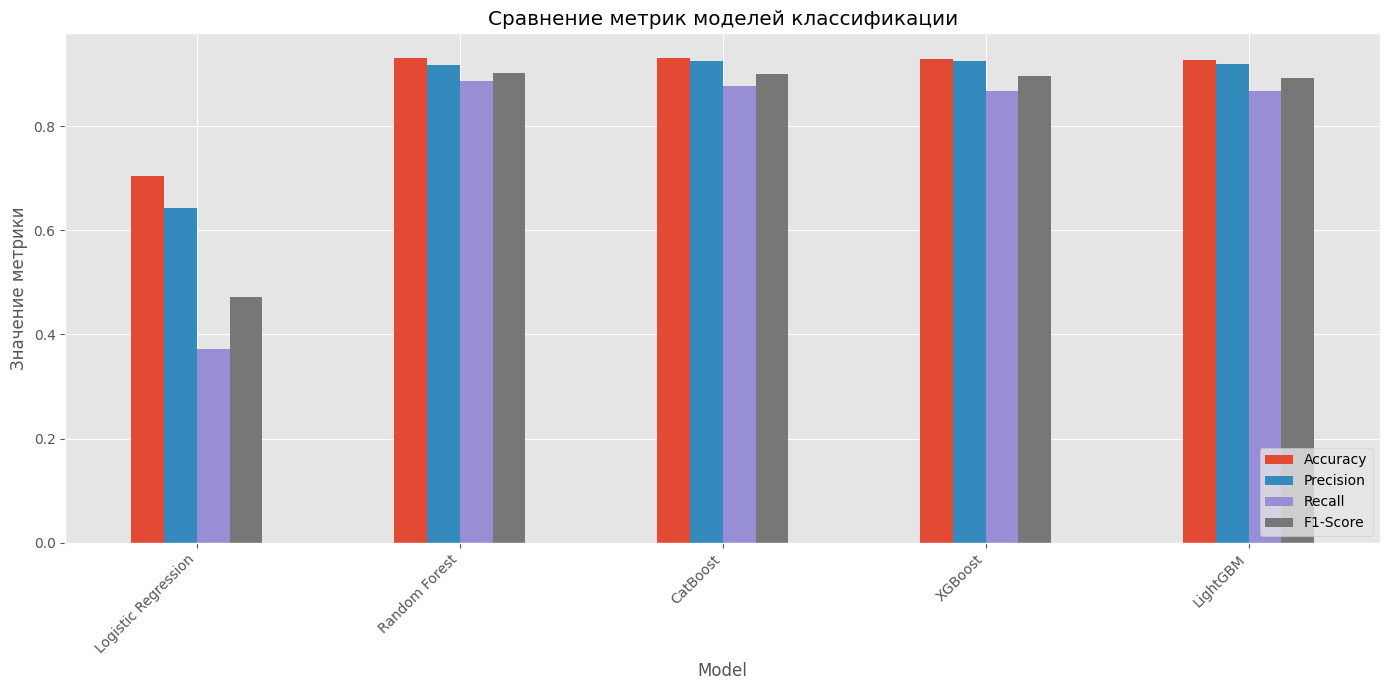

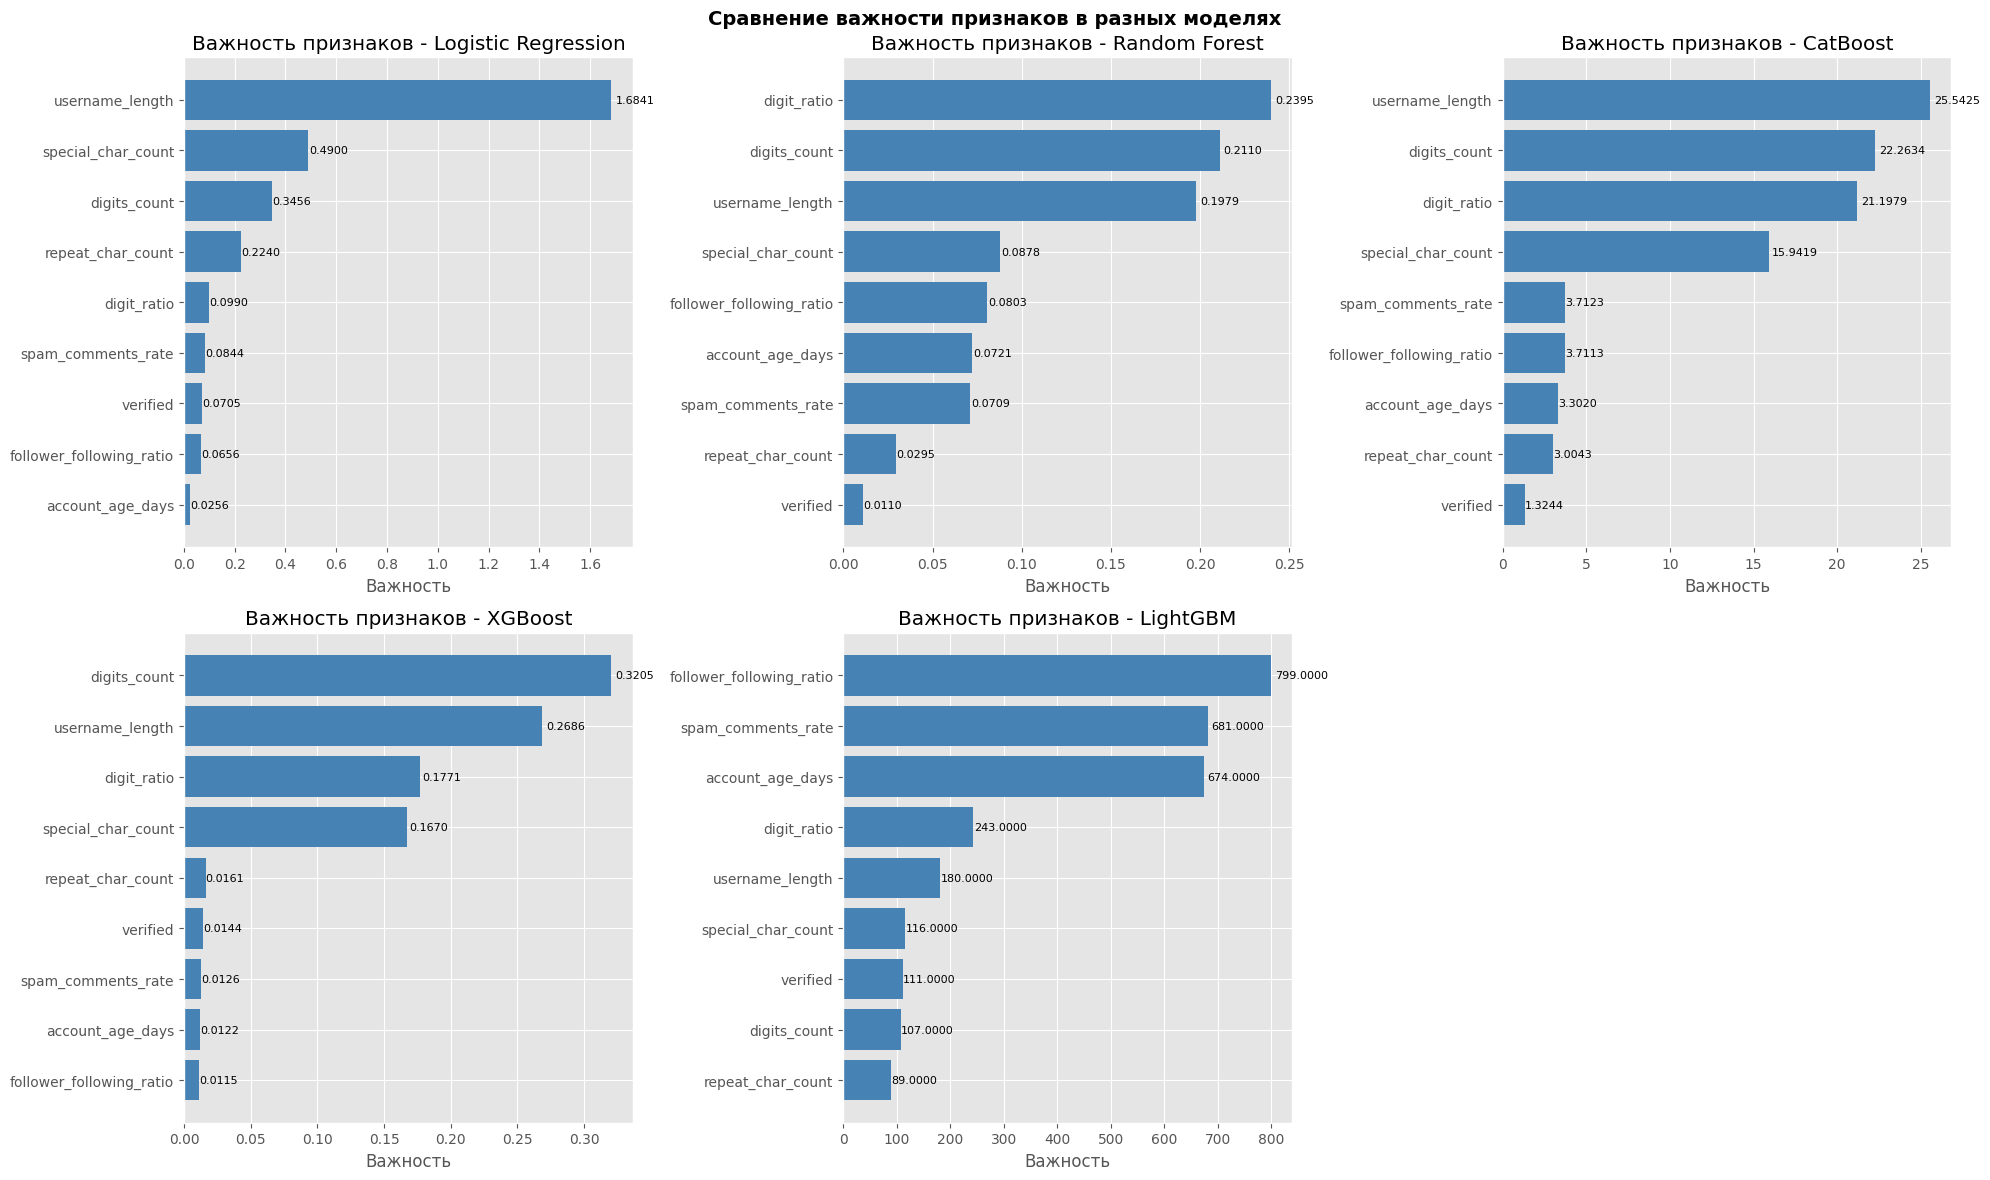


СРАВНЕНИЕ ВАЖНОСТИ ПРИЗНАКОВ ПО МОДЕЛЯМ

Топ-10 признаков по средней важности:
username_length             0.2654
digits_count                0.1803
digit_ratio                 0.1483
special_char_count          0.1223
follower_following_ratio    0.0833
spam_comments_rate          0.0750
account_age_days            0.0701
repeat_char_count           0.0356
verified                    0.0197
Name: Average_importance, dtype: float64


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  # <-- Добавлен Random Forest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Классификация
def train_classification_models(X_train, X_test, y_train, y_test):
    # Для логистической регрессии масштабируем данные
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
        'XGBoost': XGBClassifier(random_state=42),
        'LightGBM': LGBMClassifier(random_state=42)
    }

    results = {}

    for name, model in models.items():
        print(f"Обучение модели {name}...")

        # Для логистической регрессии используем масштабированные данные
        if name == 'Logistic Regression':
            X_tr, X_te = X_train_scaled, X_test_scaled
        else:
            X_tr, X_te = X_train, X_test

        model.fit(X_tr, y_train)

        # Прогнозы
        y_pred = model.predict(X_te)
        y_pred_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else None

        # Метрики
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1': report['1']['f1-score'],
            'report': report
        }

        print(f"{name}: Accuracy = {accuracy:.4f}")
        print(f"  Precision: {report['1']['precision']:.4f}, Recall: {report['1']['recall']:.4f}, F1: {report['1']['f1-score']:.4f}")
        print()

    return results

# Обучение моделей классификации
classification_results = train_classification_models(X_train, X_test, y_train, y_test)

# Сравнение результатов
classification_df = pd.DataFrame({
    'Model': list(classification_results.keys()),
    'Accuracy': [results['accuracy'] for results in classification_results.values()],
    'Precision': [results['precision'] for results in classification_results.values()],
    'Recall': [results['recall'] for results in classification_results.values()],
    'F1-Score': [results['f1'] for results in classification_results.values()]
})

print("\nСравнение моделей классификации:")
print(classification_df)

# Визуализация сравнения
plt.figure(figsize=(14, 7))
classification_df.set_index('Model').plot(kind='bar', ax=plt.gca())
plt.title('Сравнение метрик моделей классификации')
plt.ylabel('Значение метрики')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Важность признаков
fig, axes = plt.subplots(2, 3, figsize=(20, 12))  #
axes = axes.flatten()

for idx, (name, results) in enumerate(classification_results.items()):
    model = results['model']
    ax = axes[idx]

    if hasattr(model, 'feature_importances_'):
        # Для tree-based моделей (Random Forest, CatBoost, XGBoost, LightGBM)
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Для логистической регрессии
        importances = np.abs(model.coef_[0])
    else:
        print(f"Модель {name} не поддерживает feature importance")
        ax.text(0.5, 0.5, f'Feature importance\nнедоступна',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{name}')
        ax.set_xlabel('Важность')
        continue

    feature_names = X.columns

    # Сортировка по важности
    indices = np.argsort(importances)[::-1]
    n_features = min(15, len(feature_names))  # Показываем топ-15 признаков

    ax.barh(range(n_features), importances[indices[:n_features]][::-1], color='steelblue')
    ax.set_yticks(range(n_features))
    ax.set_yticklabels(feature_names[indices[:n_features]][::-1])
    ax.set_title(f'Важность признаков - {name}')
    ax.set_xlabel('Важность')

    # Добавляем значения на график
    for i, (value, feature) in enumerate(zip(importances[indices[:n_features]][::-1],
                                            feature_names[indices[:n_features]][::-1])):
        ax.text(value + value*0.01, i, f'{value:.4f}', va='center', fontsize=8)

# Скрываем неиспользуемые subplots если есть
for i in range(len(classification_results), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Сравнение важности признаков в разных моделях', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Дополнительно: сравнительная таблица важности признаков
print("\n" + "="*70)
print("СРАВНЕНИЕ ВАЖНОСТИ ПРИЗНАКОВ ПО МОДЕЛЯМ")
print("="*70)

# Создаем DataFrame с важностью признаков для каждой модели
importance_df = pd.DataFrame(index=X.columns)

for name, results in classification_results.items():
    model = results['model']

    if hasattr(model, 'feature_importances_'):
        importance_df[f'{name}_importance'] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance_df[f'{name}_importance'] = np.abs(model.coef_[0])
    else:
        importance_df[f'{name}_importance'] = np.nan

# Нормализуем важность признаков для сравнения
importance_normalized = importance_df.copy()
for col in importance_df.columns:
    if importance_df[col].notna().all():
        importance_normalized[col] = importance_df[col] / importance_df[col].sum()

# Топ-10 признаков по средней важности
if 'Logistic Regression_importance' in importance_normalized.columns:
    importance_normalized['Average_importance'] = importance_normalized.mean(axis=1, skipna=True)
    print("\nТоп-10 признаков по средней важности:")
    print(importance_normalized['Average_importance'].sort_values(ascending=False).head(10).round(4))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[11:15:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




[LightGBM] [Info] Number of positive: 847, number of negative: 1553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352917 -> initscore=-0.606243
[LightGBM] [Info] Start training from score -0.606243

Результаты моделей:
                 Model  Accuracy  Precision  Recall     F1
0  Logistic Regression     0.705      0.642   0.373  0.472
1        Random Forest     0.932      0.917   0.887  0.902
2              XGBoost     0.928      0.925   0.868  0.895
3             LightGBM     0.927      0.920   0.868  0.893
4             CatBoost     0.932      0.925   0.877  0.901


/tmp/ipython-input-3519735454.py:73: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-3519735454.py:73: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-3519735454.py:73: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-3519735454.py:73: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



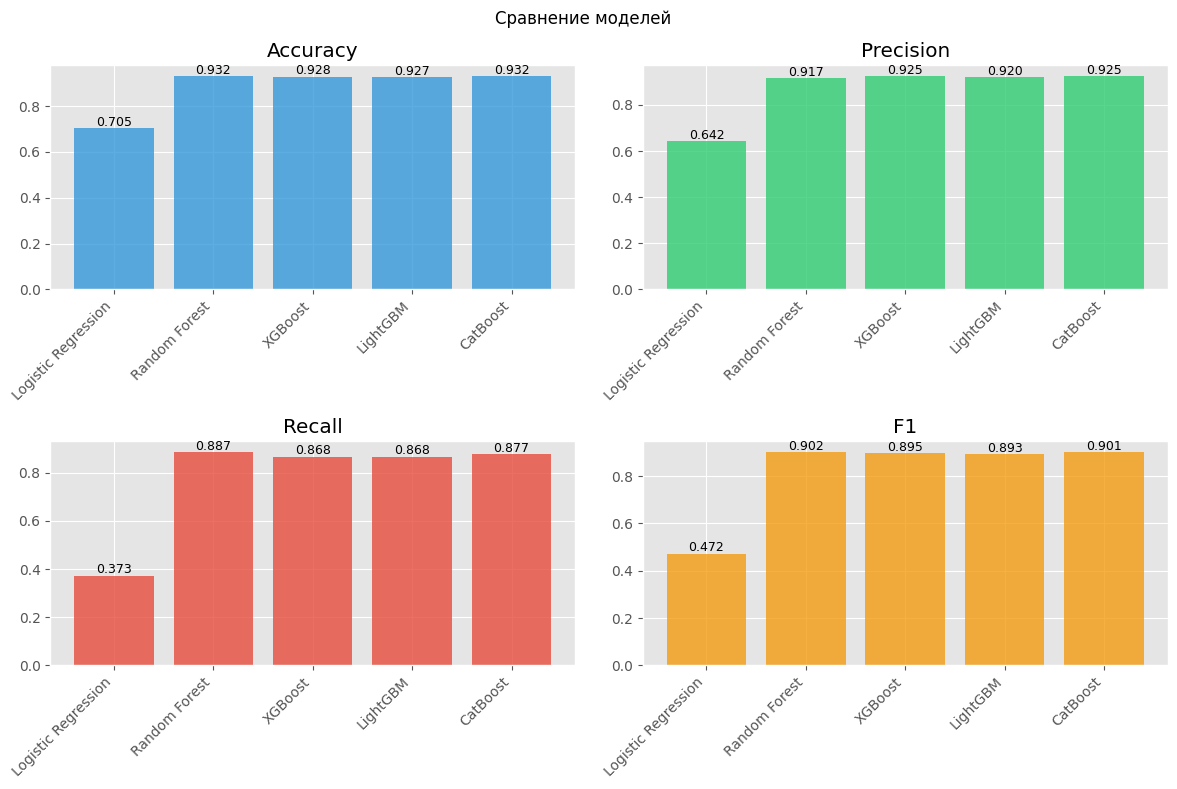

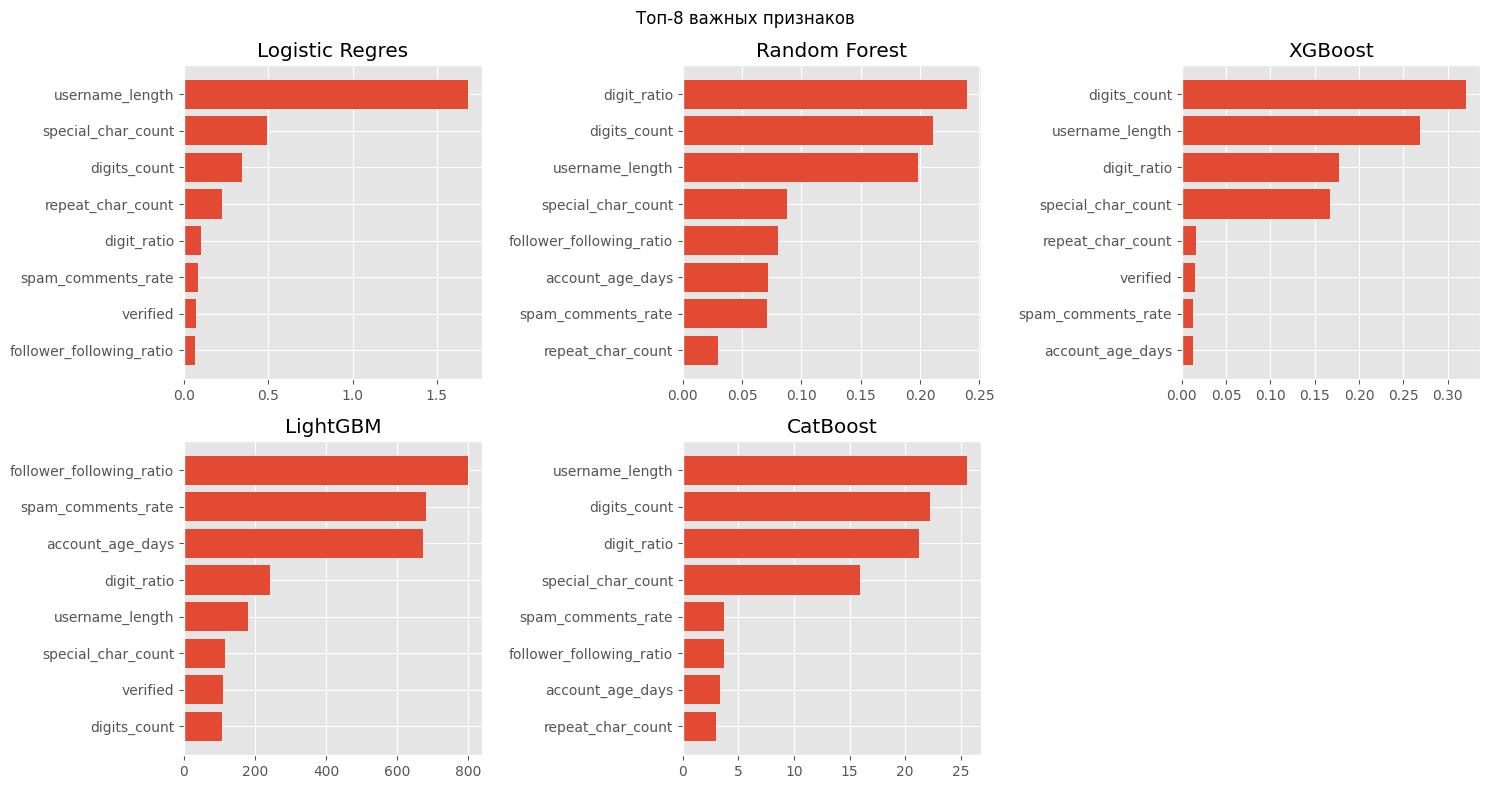


Лучшая модель: Random Forest
F1-score: 0.902

Топ-5 признаков (Random Forest):
1. digit_ratio: 0.2395
2. digits_count: 0.2110
3. username_length: 0.1979
4. special_char_count: 0.0878
5. follower_following_ratio: 0.0803


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Масштабируем для логистической регрессии
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Обучаем модели
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_s, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

cb = CatBoostClassifier(random_state=42, verbose=0)
cb.fit(X_train, y_train)

# Список моделей
models = [
    ('Logistic Regression', logreg, X_test_s),
    ('Random Forest', rf, X_test),
    ('XGBoost', xgb, X_test),
    ('LightGBM', lgbm, X_test),
    ('CatBoost', cb, X_test)
]

# Считаем метрики
results = []
for name, model, X_test_data in models:
    preds = model.predict(X_test_data)

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    results.append([name, acc, prec, rec, f1])

# Таблица результатов
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
print("\nРезультаты моделей:")
print(results_df.round(3))

# График метрик
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    values = results_df[metric].values

    bars = ax.bar(results_df['Model'], values, color=color, alpha=0.8)
    ax.set_title(metric)
    ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.3f}', ha='center', fontsize=9)

plt.suptitle('Сравнение моделей')
plt.tight_layout()
plt.show()

# Важность признаков
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (name, model, _) in enumerate(models):
    ax = axes[i]

    if name == 'Logistic Regression':
        if hasattr(model, 'coef_'):
            imp = np.abs(model.coef_[0])
    elif hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
    else:
        continue

    # Топ-8 признаков
    top_idx = np.argsort(imp)[-8:]
    ax.barh(range(8), imp[top_idx])
    ax.set_yticks(range(8))
    ax.set_yticklabels([X.columns[i] for i in top_idx])
    ax.set_title(name[:15])

# Убираем лишний график
axes[-1].set_visible(False)

plt.suptitle('Топ-8 важных признаков')
plt.tight_layout()
plt.show()

# Лучшая модель
best_idx = results_df['F1'].idxmax()
print(f"\nЛучшая модель: {results_df.loc[best_idx, 'Model']}")
print(f"F1-score: {results_df.loc[best_idx, 'F1']:.3f}")

# Топ-5 признаков из случайного леса (обычно самые стабильные)
if hasattr(rf, 'feature_importances_'):
    rf_imp = rf.feature_importances_
    top5_idx = np.argsort(rf_imp)[-5:][::-1]

    print("\nТоп-5 признаков (Random Forest):")
    for i, idx in enumerate(top5_idx, 1):
        print(f"{i}. {X.columns[idx]}: {rf_imp[idx]:.4f}")

Все
 модели показывают очень высокую точность (92.7-93.2%)

CatBoost демонстрирует лучший результат по всем метрикам

Различия между моделями незначительны, что говорит о хорошем качестве данных и выбранных признаков